In [1]:
import sys
sys.path.append('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/')

In [2]:
import os 
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Hyperparam_Testing.Testing_Notebooks.Common_Functions as cf 
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras import models 
import seaborn as sb
from keras.regularizers import l2
from Hyperparam_Testing.Testing_Notebooks import chirallag as cL

import matplotlib
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'text.usetex': True})
matplotlib.rcParams.update({'text.usetex': True})
matplotlib.rcParams.update({'mathtext.fontset': 'cm'})
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
#The process for calculation of a transformed field has now become a bit more intense. 
#Rotate fields 

In [4]:
N=3
gens = cL.gen_gellman(3)
F0 = 1


        
liststrucSU3 = np.array([[1,2,3,1],[1,4,7,.5],[1,5,6,-.5],[2,4,6,.5],[2,5,7,.5],[3,4,5,.5],[3,6,7,-.5],[4,5,8,3**0.5/2],[6,7,8,3**0.5/2]])
liststrucSU2 = np.array([[1,2,3,1],[3,2,1,1]])

epsmax = 100
epsmin = 0.001
eps_intervals=500
number_predictions=1000000

adjointSU3 = cf.adjointSUN(3,liststrucSU3)

In [5]:
# Compare Transformations



pi=np.random.rand(number_predictions,N*N-1)**.25
dpi=np.random.rand(number_predictions,N*N-1)**.25

# Get epsilons, create copies
eps_vals=np.logspace(np.log10(epsmin),np.log10(epsmax),num=eps_intervals)
eps = np.zeros(number_predictions)
for i,val in enumerate(eps_vals): 
    eps[i*int(number_predictions/eps_intervals):(i+1)*int(number_predictions/eps_intervals)] = val
# Set leftovers to max value
eps[(i+1)*int(number_predictions/eps_intervals):]=val

# SO(N) transformations
SO_trans = cf.get_SO_trans(eps,N*N-1)

SO_pi = cf.apply_trans(SO_trans,pi)
SO_dpi = cf.apply_trans(SO_trans,dpi)

# SU(N) transformations

SU_trans = cf.get_SU_trans(eps,N,liststrucSU3,number_predictions)

SU_pi = cf.apply_trans(SU_trans,pi)
SU_dpi = cf.apply_trans(SU_trans,dpi)


# Get potential values, only care about real part (non zero imag should just be numerical precision errors)

orig_V = cL.get_V(pi,dpi,gens,F0).real
SO_V = cL.get_V(SO_pi,SO_dpi,gens,F0).real
SU_V = cL.get_V(SU_pi,SU_dpi,gens,F0).real

SO_Vdiff = (SO_V - orig_V)/orig_V
SU_Vdiff = (SU_V - orig_V)/orig_V

rand_means = np.mean(np.hstack([np.abs(pi) , np.abs(dpi)]),axis=-1)

Text(0, 0.5, 'Frequency Density')

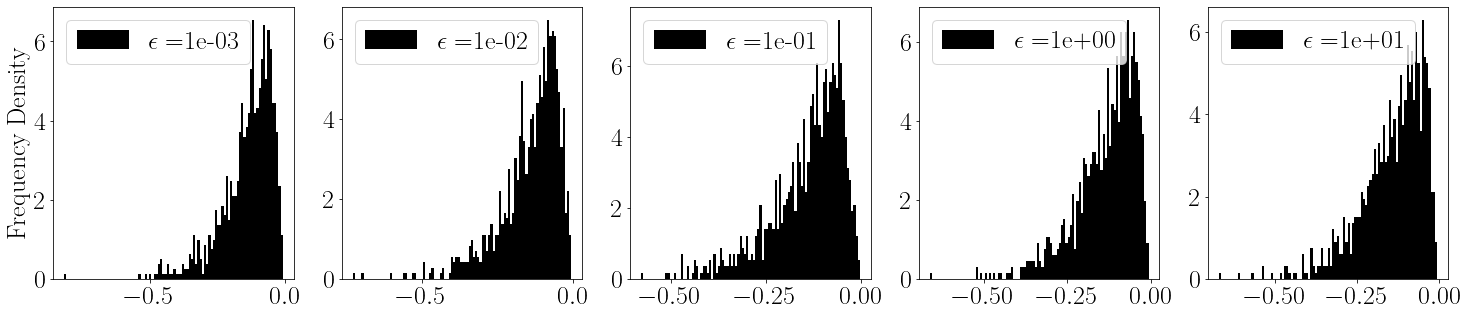

In [ ]:
fig,ax = plt.subplots(1,5, figsize = (25,5))

for i, epsilon in enumerate(eps_vals):
    if i%100 == 0:
        lower_index = i*1000
        upper_index = (i+1)*1000
        ax[i//100].hist(SU_V[lower_index:upper_index],bins = 100, density= True,color = 'black', label = ( '$\epsilon =${:.0e}'.format(epsilon)))
        ax[i//100].legend()
ax[0].set_ylabel('Frequency Density')

Text(0, 0.5, 'Frequency Density')

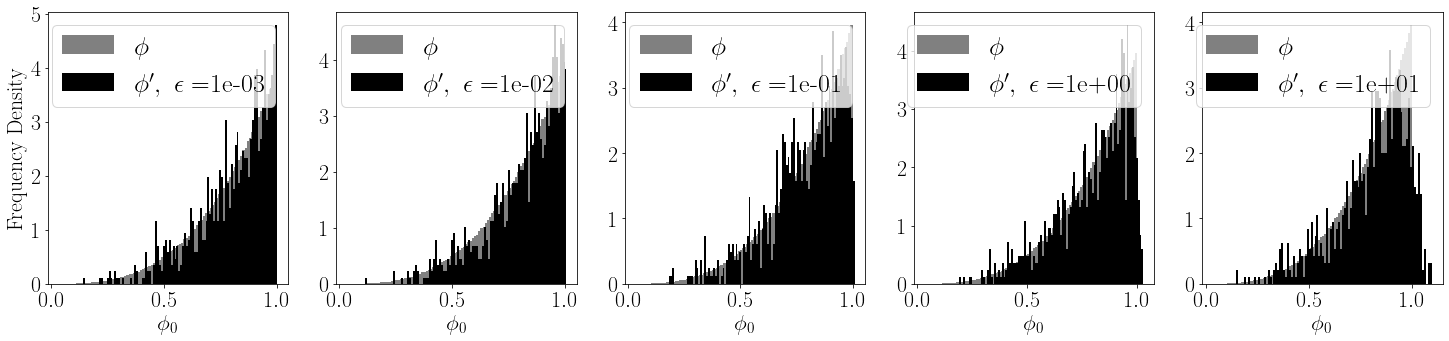

In [ ]:
fig,ax = plt.subplots(1,5, figsize = (25,5))
phi = np.random.rand(1000000,1)**0.25

for i, epsilon in enumerate(eps_vals):
    if i%100 == 0:
        lower_index = i*1000
        upper_index = (i+1)*1000
        ax[i//100].hist(phi, density = True, color ='grey',bins = 100,label = '$\phi$')
        ax[i//100].hist(SU_pi[lower_index:upper_index,0],bins = 100, density= True,color = 'black', label = ( '$\phi\',\ \epsilon =${:.0e}'.format(epsilon)))
        ax[i//100].legend()
        ax[i//100].set_xlabel(r'$\phi_{}$'.format(0))
        
ax[0].set_ylabel('Frequency Density')

In [ ]:
filter_model_path = '/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Hyperparam_Testing/Testing_Notebooks/Optimised_Network/Saved_Optimised_Networks/5_107.0datapoints.h5'
filter_model = models.load_model(filter_model_path)

In [ ]:
final_model_path = '/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Hyperparam_Testing/Testing_Notebooks/Optimised_Network/107.0datapoints_cut_0.1_.h5'
final_model = models.load_model(final_model_path)

In [ ]:
SO_trans.shape

(1000000, 8, 8)

In [ ]:
npi = np.hstack((pi,dpi))
n_SU_pi = np.hstack((SU_pi,SU_dpi))
n_SO_pi = np.hstack((SO_pi,SO_dpi))


In [ ]:
#First Pass 
#Calculate approximate potential values of transformed field
V_SO_initial_nn = filter_model.predict(n_SO_pi)
V_SU_initial_nn = filter_model.predict(n_SU_pi)
#Find indexes of fields which obey condition 
index_SO = np.where(V_SO_initial_nn>0.1)
index_SU = np.where(V_SU_initial_nn>0.1)

#Filter_eps
filter_SO_eps = eps[index_SO[0]]
filter_SU_eps = eps[index_SU[0]]

#Transform Filtered fields
filter_SO_pi = cf.apply_trans( SO_trans[index_SO[0]], pi[index_SO[0]])
filter_SO_dpi = cf.apply_trans(SO_trans[index_SO[0]],dpi[index_SO[0]])

filter_SU_pi = cf.apply_trans( SU_trans[index_SU[0]], pi[index_SU[0]])
filter_SU_dpi = cf.apply_trans(SU_trans[index_SU[0]],dpi[index_SU[0]])

#Stack Filtered Fields 
filter_SU_npi = np.hstack((filter_SU_pi,filter_SU_dpi))
filter_SO_npi = np.hstack((filter_SO_pi,filter_SO_dpi))

#Evaluate Filtered Fields
filter_SU_V = final_model.predict(filter_SU_npi)
filter_SO_V = final_model.predict(filter_SO_npi)

#Delta V
delta_V_SO_f = (filter_SO_V.transpose() + orig_V[index_SO[0]])/-orig_V[index_SO[0]]  
delta_V_SU_f = (filter_SU_V.transpose() + orig_V[index_SU[0]])/-orig_V[index_SU[0]]  

delta_V_SO_f = (delta_V_SO_f)[0]
delta_V_SU_f = (delta_V_SU_f)[0]

In [ ]:
V_SO_nn = final_model.predict(n_SO_pi)
V_SU_nn = final_model.predict(n_SU_pi)


delta_V_SO_nn = (V_SO_nn.transpose() + orig_V)/-orig_V  
delta_V_SU_nn = (V_SU_nn.transpose() + orig_V)/-orig_V  

delta_V_SO_nn = delta_V_SO_nn.transpose()
delta_V_SU_nn = delta_V_SU_nn.transpose()


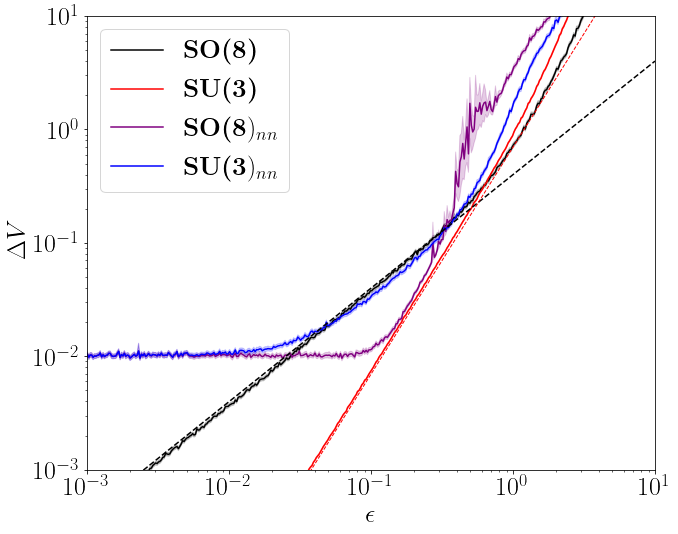

In [ ]:
fig,ax = plt.subplots(1,figsize=(10,8))

matplotlib.rcParams.update({'legend.fontsize': 26})
matplotlib.rcParams.update({'font.size': 26})
matplotlib.rcParams.update({'font.weight': 'bold'})

#The Epsilon arrays are now not of the same shape so different dataframes should be used 
data = pd.DataFrame({'epsilon':eps,'SOdiff':np.abs(SO_Vdiff),'SUdiff':np.abs(SU_Vdiff)})
data_SU = pd.DataFrame({'epsilon':filter_SU_eps, 'SUdiff_nn':np.abs(delta_V_SU_f)})
data_SO = pd.DataFrame({'epsilon':filter_SO_eps, 'SOdiff_nn':np.abs(delta_V_SO_f)})

sb.lineplot(data=data,x='epsilon',y='SOdiff',label=r'\textbf{SO(8)'           ,ci=95,color = 'black' )
sb.lineplot(data=data,x='epsilon',y='SUdiff',label=r'\textbf{SU(3)'           ,ci=95, color = 'Red')
sb.lineplot(data=data_SU,x='epsilon',y='SUdiff_nn',label=r'\textbf{SO(8$)_{nn}$}',ci=95, color = 'Purple')
sb.lineplot(data=data_SO,x='epsilon',y='SOdiff_nn',label=r'\textbf{SU(3$)_{nn}$}',ci=95, color = 'Blue')

x = np.logspace(-3,1,100)
y1 = np.exp(x)-(1+x)
y = 1/(1-x)-(1)
#ax.plot(x,y,color="green")
ax.plot(x,x*0.4,color="Black",linestyle='--')
ax.grid(False)
#ax.plot(x,y1,color="orange")
ax.plot(x,(x**2)*0.7,color="Red",linestyle='--',linewidth = 1)
#ax.plot(x,np.ones_like(x)*np.min(validation_MAPE)/100, color = 'grey',linestyle = '--', label = r'\textbf{Network MAPE}')

ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel(r'$\Delta V$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(False)
ax.legend()
ax.set_ylim(1e-3,10)
ax.set_xlim(1e-3,10)
fig.tight_layout()
#fig.savefig('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Figures/DeltaV_inital_1.png',dpi=400,transparent=True)

In [ ]:
#This takes a mean and an stdev of the deltaV of points which have been transformed for same eps 

SO_Vdiff_eps = [np.abs(SO_Vdiff[np.where(eps==val)]) for val in eps_vals] 
mean_SO = np.mean(SO_Vdiff_eps,axis=-1)
std_dev_SO = np.std(SO_Vdiff_eps,axis=-1)
std_error_SO = std_dev_SO/np.sqrt([len(s) for s in SO_Vdiff_eps])

SU_Vdiff_eps = [np.abs(SU_Vdiff[np.where(eps==val)]) for val in eps_vals]
mean_SU = np.mean(SU_Vdiff_eps,axis=-1)
std_dev_SU = np.std(SU_Vdiff_eps,axis=-1)
std_error_SU = std_dev_SU/np.sqrt([len(s) for s in SU_Vdiff_eps])

SO_F_eps = [np.abs(delta_V_SO_f[np.where(filter_SO_eps==val)]) for val in eps_vals]
mean_SO_F_nn = [np.mean(SO_F_eps[i]) for i in range(eps_intervals)]
std_SO_F_nn  = [np.std(SO_F_eps[i]) for i in range(eps_intervals)]
ste_SO_F_nn = std_SO_F_nn/np.sqrt([len(s) for s in SO_F_eps])

SU_F_eps  = [np.abs(delta_V_SU_f[np.where(filter_SU_eps==val)]) for val in eps_vals]
mean_SU_F_nn = [np.mean(SU_F_eps[i]) for i in range(eps_intervals)]
std_SU_F_nn  = [np.std(SU_F_eps[i]) for i in range(eps_intervals)]
ste_SU_F_nn  = std_SU_F_nn/np.sqrt([len(s) for s in SU_F_eps])

In [ ]:
# Create windows
from numpy.lib.stride_tricks import sliding_window_view
from scipy.optimize import curve_fit as fit
def p5(x,a0,a1,a2):
    return a0+x*a1+a2*x**2

p0 = [0,0,1]
window = 100
step=1

eps_windowed = sliding_window_view(eps_vals,window)[::step]
mean_SO_windowed = sliding_window_view(mean_SO,window)[::step]
mean_SU_windowed = sliding_window_view(mean_SU,window)[::step]
#mean_arb_windowed = sliding_window_view(mean_arb,window)[::step]

mean_SO_network_windowed = sliding_window_view(mean_SO_F_nn,window)[::step]
mean_SU_network_windowed = sliding_window_view(mean_SU_F_nn,window)[::step]
#mean_arb_network_windowed = sliding_window_view(mean_arb_network,window)[::step]


std_error_SO_windowed = sliding_window_view(std_error_SO,window)[::step]
std_error_SU_windowed = sliding_window_view(std_error_SU,window)[::step]
#std_error_arb_windowed = sliding_window_view(std_error_arb,window)[::step]

std_error_SO_network_windowed = sliding_window_view(ste_SO_F_nn,window)[::step]
std_error_SU_network_windowed = sliding_window_view(ste_SU_F_nn,window)[::step]
#td_error_arb_network_windowed = sliding_window_view(std_error_arb_network,window)[::step]

In [ ]:
SO_fits=np.zeros((eps_windowed.shape[0],len(p0)))
SU_fits=np.zeros((eps_windowed.shape[0],len(p0)))
arb_fits=np.zeros((eps_windowed.shape[0],len(p0)))

SO_network_fits=np.zeros((eps_windowed.shape[0],len(p0)))
SU_network_fits=np.zeros((eps_windowed.shape[0],len(p0)))
arb_network_fits=np.zeros((eps_windowed.shape[0],len(p0)))


SO_covs=np.zeros((eps_windowed.shape[0],len(p0),len(p0)))
SU_covs=np.zeros((eps_windowed.shape[0],len(p0),len(p0)))
#arb_covs=np.zeros((eps_windowed.shape[0],len(p0),len(p0)))

SO_network_covs=np.zeros((eps_windowed.shape[0],len(p0),len(p0)))
SU_network_covs=np.zeros((eps_windowed.shape[0],len(p0),len(p0)))
#arb_network_covs=np.zeros((eps_windowed.shape[0],len(p0),len(p0)))

bound = (-0.001,10)
for i,these_eps_vals in enumerate(eps_windowed):
    #print(i/len(eps_windowed))
    SO_fit_params,SO_fit_cov=fit(p5,these_eps_vals,mean_SO_windowed[i],p0=p0,
                                                      sigma=std_error_SO_windowed[i],absolute_sigma=True,bounds=bound)
    SU_fit_params,SU_fit_cov=fit(p5,these_eps_vals,mean_SU_windowed[i],p0=p0,
                                                      sigma=std_error_SU_windowed[i],absolute_sigma=True,bounds=bound)
    
    
    SU_network_fit_params,SU_network_fit_cov=fit(p5,these_eps_vals,mean_SU_network_windowed[i],
                                                                    p0=p0,sigma=std_error_SU_network_windowed[i],absolute_sigma=True,
                                                                    bounds=bound)
    SO_network_fit_params,SO_network_fit_cov=fit(p5,these_eps_vals,mean_SO_network_windowed[i],
                                                                    p0=p0,sigma=std_error_SO_network_windowed[i],absolute_sigma=True,
                                                                    bounds=bound)
    



    SO_fits[i]=(SO_fit_params)
    SO_covs[i]=(SO_fit_cov)
    SU_fits[i]=(SU_fit_params)
    SU_covs[i]=(SU_fit_cov)
    

    SO_network_fits[i]=(SO_network_fit_params)
    SO_network_covs[i]=(SO_network_fit_cov)
    SU_network_fits[i]=(SU_network_fit_params)
    SU_network_covs[i]=(SU_network_fit_cov)
    #arb_network_fits[i]=(arb_network_fit_params)
    #arb_network_covs[i]=(arb_network_fit_cov)

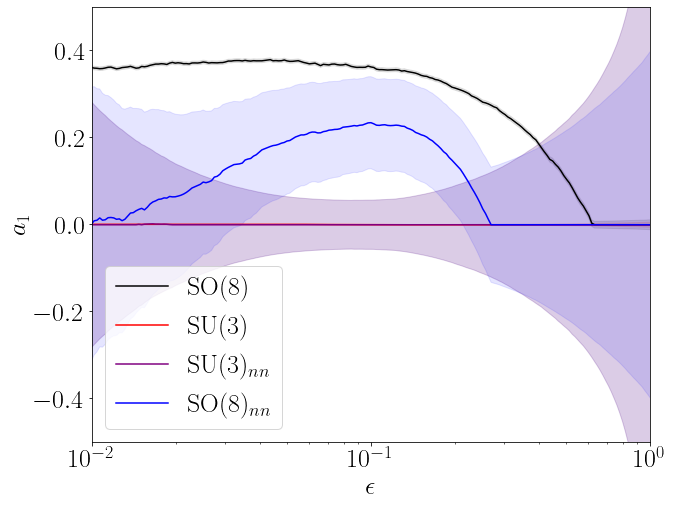

In [ ]:
# Now SU(3)
fig,ax = plt.subplots(1,1,figsize=(10,8))
colors = sb.color_palette('colorblind',4)

###AX0
eps_mid=np.median(eps_windowed,axis=-1)
coeff = 1

y=np.array(SO_fits)[:,coeff]
ci = np.sqrt(np.array(SO_covs)[:,coeff,coeff])
ax.semilogx(eps_mid, y*np.power(eps_mid,0),label=r'SO(8)',color='black')
ax.fill_between(eps_mid, (y-ci)*np.power(eps_mid,0), (y+ci)*np.power(eps_mid,0), color='black', alpha=.1)

y=np.array(SU_fits)[:,coeff]
ci = np.sqrt(np.array(SU_covs)[:,coeff,coeff])
ax.semilogx(eps_mid, y*np.power(eps_mid,0),label=r'SU(3)',color='red')
ax.fill_between(eps_mid, (y-ci)*np.power(eps_mid,0), (y+ci)*np.power(eps_mid,0), color='red', alpha=.1)



#print(y)
y=np.array(SU_network_fits)[:,coeff]
ci = np.sqrt(np.array(SU_network_covs)[:,coeff,coeff])
ax.semilogx(eps_mid, y*np.power(eps_mid,0),label=r'SU(3$)_{nn}$',color='purple')
ax.fill_between(eps_mid, (y-ci)*np.power(eps_mid,0), (y+ci)*np.power(eps_mid,0), color='indigo', alpha=.2)

y=np.array(SO_network_fits)[:,coeff]
ci =np.sqrt(np.array(SO_network_covs)[:,coeff,coeff])
ax.semilogx(eps_mid, y*np.power(eps_mid,0),label=r'SO(8$)_{nn}$',color='blue')
ax.fill_between(eps_mid, (y-ci)*np.power(eps_mid,0), (y+ci)*np.power(eps_mid,0), color='blue', alpha=.1)



ax.set_xlabel('$\epsilon$')
ax.set_ylabel('$a_{}$'.format(coeff))
ax.set_ylim(-0.5,0.5)
ax.set_xlim(0.01,1)
ax.legend()


import datetime
time = datetime.date.today()
fig.savefig('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Figures/sliding_window_a_{}_{}_2net.png'.format(coeff,time),dpi = 300)